# Dependences

In [1]:
import sys
from pathlib import Path
import json
import warnings
import copy
from pprint import pprint

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Add the root path to sys.path
root_path = Path().resolve().parent
sys.path.append(str(root_path))

from src import PROCESSED_PATH, MODEL_PATH, LOGS_PATH
from src.data_processing import create_dataset, process_data
from src.model import RecommenderEngineModel
from src.train_functions import train_model
from src.experiments import train_baseline, batch_size_exp, deep_layers_exp, resample_exp
from src.feature_selection import FeatureSelection

# Hide warnings
warnings.filterwarnings("ignore")

SEED = 42

# Set seed for reproducibility
tf.random.set_seed(SEED)

2025-04-14 15:02:13.712157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-14 15:02:13.712216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-14 15:02:13.713034: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 15:02:13.718632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-14 15:02:14.358462: W tensorflow/compiler/tf2

# Data Loading

In [2]:
products_df_path = PROCESSED_PATH / "products_df.parquet"
clicks_df_path = PROCESSED_PATH / "clicks_df.parquet"

if all([not products_df_path.exists(), not clicks_df_path.exists()]):
    clicks_df, products_df = process_data()
    clicks_df.to_parquet(clicks_df_path)
    products_df.to_parquet(products_df_path)

# Load data
products_df = pd.read_parquet(products_df_path)
clicks_df = pd.read_parquet(clicks_df_path)

# Parameters
The following parameters are considered baseline or "vanilla," serving as a foundation for initial experimentation before fine-tuning through hyperparameter optimization.

Some this parameters were inspired from [Tensorflow Tutorials](https://www.tensorflow.org/recommenders/examples/quickstart) and from experimentation behind the scenes.

In [3]:
params = {
    "logs_path": "",
    "train_size": 0.8,
    "n_samples": clicks_df.shape[0], # save the number of user interactions
    "tower": {
        "query": [
            "time",
            "cat-user_id",
            "cat-channel",
            "cat-device_type",
            "int-hour",
            "int-day_of_week",
            "text-query_text",
            "seq-seq_product_id",
            "seq-seq_category_name",
            "score",
            ],
        "item": [
            "cat-product_id",
            "cat-category_name",
            "cat-merchant_name",
            "cat-merchant_city",
            "cat-merchant_state",
            "cat-merchant_region",
            "int-free_shipping",
            "int-is_sold_out",
            "int-editor_pick",
            "int-on_sale",
            "text-product_name",
            "disc-sales_last_week",
            "disc-sales_last_month",
            "disc-sales_last_year",
            "disc-price_in_cents",
            "disc-reviews",
            "norm-sales_last_week",
            "norm-sales_last_month",
            "norm-sales_last_year",
            "norm-price_in_cents",
            "norm-reviews",
        ]
    },
    "callbacks": {
        "early_stopping": {
            "patience": 3,
            "start_from_epoch": 5,
            "delta_retrieval": 0.01,
            "delta_rating": 0.01,
            # I"ll focus on top 50 because is unlikely a user will show more than 50 products
            "retrieval_metric": "val_factorized_top_k/top_50_categorical_accuracy",
            "rating_metric": "val_root_mean_squared_error"
        }
    },
    # Baseline Model Hyperparameters
    "model": {
        "max_epochs": 300,
        "batch_size": 128,
        "learning_rate": {
            "initial_learning_rate": 0.1, # starting from 0.1 further decay until early stopping is reached
            # In order to decay two orders of magnitude in 8 (start_from_epoch + patience) epochs from 0.1 to 0.001 (plot in next cell)
            "decay_rate": 0.57,
            "staircase": True
        },
        # embedding weight shared among all features where emb_size = (np.log2(input_dim) + 1) * emb_weigh
        "emb_weight": 8,
        # note that this model doesn"t have deep layers defined, only a dense layer to ensure same output size among the towers
        "query_layers": [32],
        "item_layers": [32],
        # rating model need one unit as output for regression
        "rating_layers": [64, 32, 1],
        "dropout": 0.1,
        # disable cross layer to keep it simple
        "cross_layer": False,
        "optimizer": "Adagrad"
    }
}

# Save parameters
json.dump(params, open(MODEL_PATH / "parameters" / "params_v1.json", "w"), indent=4)

# LR schedule

I will set the LR schedule to decay two orders of magnitude (from 0,1 to 0,001 for instance) in 8 (start_from_epoch + patience) epochs. That's the minimum number of epochs required for early stopping.

2025-04-14 15:02:16.297581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-14 15:02:16.341959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-14 15:02:16.342033: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-14 15:02:16.349046: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-14 15:02:16.349172: I external/local_xla/xla/stream_executor

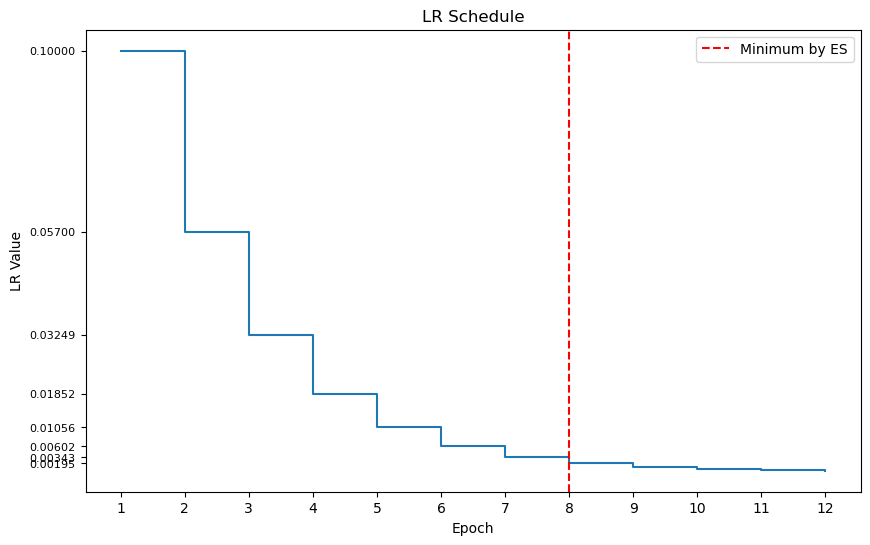

In [4]:
# Epochs to display
n = 12
# Minimum number of epochs needed by Early Stopping schedule
params_es = params["callbacks"]["early_stopping"]
min_early_stopping = params_es["start_from_epoch"] + params_es["patience"]
# Number of steps within a epoch given the batch size
n_steps = np.ceil(params["n_samples"] * params["train_size"] / params["model"]["batch_size"])

# Set the decay_steps argument to the number of steps in a epoch
params["model"]["learning_rate"]["decay_steps"] = n_steps

# Set up Exponential scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(**params["model"]["learning_rate"])

# Compute LR schedule
lr_values = [lr_schedule(i * n_steps).numpy() for i in range(n)]

# Plot LR schedule
fig = plt.figure(figsize=(10, 6))
plt.step(x=range(1, n + 1), y=lr_values, where="post")
plt.axvline(x=min_early_stopping, color="red", linestyle="--", label="Minimum by ES")
plt.xlabel("Epoch")
plt.ylabel("LR Value")
plt.xticks(range(1, n + 1))
plt.yticks(lr_values[:8], fontsize= 8)
plt.title("LR Schedule")
plt.legend()
plt.show()

# Split Datasets

In [5]:
# Create datasets from the whole data to further vocabulary building
user_features = params["tower"]["query"]
product_features = params["tower"]["item"]
features = user_features + product_features
clicks_ds = create_dataset(clicks_df, features)
products_ds = create_dataset(products_df, features)

# Data length
n_data = clicks_df.shape[0]
train_samples = int(params["train_size"] * n_data)

y = clicks_df["score"]
# Split without shuffling by the sequential features
clicks_train_df, clicks_val_df = train_test_split(
    clicks_df,
    test_size=1-params["train_size"],
    shuffle=False
)

# Split with shuffling in case the sequential features won"t be used, stratify to ensure target consistency among sets
clicks_train_df_sh, clicks_val_df_sh = train_test_split(
    clicks_df,
    test_size=1-params["train_size"],
    stratify=y,
    random_state = SEED
)

# Load as dataset
clicks_train_ds= create_dataset(clicks_train_df, features)
clicks_val_ds = create_dataset(clicks_val_df, features)
clicks_train_ds_sh = create_dataset(clicks_train_df_sh, features)
clicks_val_ds_sh = create_dataset(clicks_val_df_sh, features)

**NOTE**: I won't use *test set* because I want to have as many data as possible for training. I will use only 80% of data for training set and 20% for validation set.
In a real world scenario, I should have a test set to evaluate the model but I would have more data as well.

# Preprocessing Dataset
To avoid repeteadly preprocessing the input data each time we train the model I'll preprocess the data before training, in the `tf.data` pipeline.

In [6]:
# Create preprocessing layers instances
model = RecommenderEngineModel(
    params=params,
    query_ds=clicks_train_ds,
    candidates_ds=products_ds,
    preprocessing= True,
)

model_sh = RecommenderEngineModel(
    params=params,
    query_ds=clicks_train_ds_sh,
    candidates_ds=products_ds,
    preprocessing= True
)
product_prep_layer = model.item_prep_layer
clicks_prep_layer, feature_dim = model.query_prep_layer, model.feature_dim
clicks_prep_layer_sh, feature_dim_sh = model_sh.query_prep_layer, model_sh.feature_dim

In [7]:
# For products, use the whole dataset
prep_products = products_ds.batch(512).map(product_prep_layer).unbatch()
# For clicks, use the train dataset
prep_clicks_train = clicks_train_ds.batch(512).map(clicks_prep_layer).map(product_prep_layer).unbatch()
prep_clicks_val = clicks_val_ds.batch(512).map(clicks_prep_layer).map(product_prep_layer).unbatch()
# For clicks with shuffling
prep_clicks_train_sh = clicks_train_ds_sh.batch(512).map(clicks_prep_layer_sh).map(product_prep_layer).unbatch()
prep_clicks_val_sh = clicks_val_ds_sh.batch(512).map(clicks_prep_layer_sh).map(product_prep_layer).unbatch()

# Experiments

In [8]:
params["model"]["max_epochs"] = 1

## Baseline Model
The model selected to perform this analysis will be a baseline model that is as simple as possible to avoid overfitting, but complex enough that it doesn't fall into underfitting. Therefore, I will have disabled the cross layer and the deep layers in the retrieval model (only use one output layer to have the same output size in each tower).

Note I can't use KFold CV because the sequential features will lead to data leakage. I will use a simple train/validation split instead.

In [9]:
baseline_path = LOGS_PATH / "baseline"
params["logs_path"] = baseline_path
if not (baseline_path / "results.csv").exists():
    # Create model instance for baseline
    model = RecommenderEngineModel(
        params=params,
        candidates_ds=prep_products,
        preprocessing= False, # Disable preprocessing
        feature_dim= feature_dim, # Feature dimension is a must, if preprocessing is disabled
        train_metrics= True # Enable training metrics
    )

    train_baseline(
        model = model,
        params = copy.deepcopy(params), # avoid mutation
        train = prep_clicks_train,
        val = prep_clicks_val
    )
history_df = pd.read_csv(baseline_path / "results.csv")

### Results

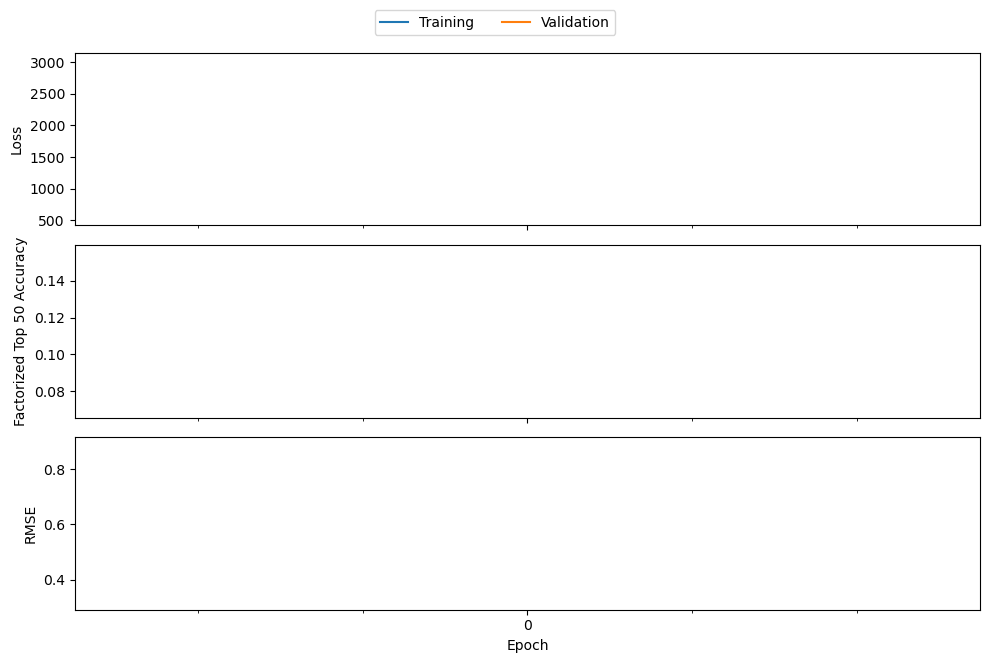

In [10]:
def baseline_analysis(history: pd.DataFrame):
    """
    Function to plot generalization curves.
    """
    fig, ax = plt.subplots(3, 1, figsize=(10, 7), sharex=True)  # Adjusted figsize for better layout

    # Plot for total loss and validation loss
    history["total_loss"].plot(ax=ax[0], label="Training")
    history["val_total_loss"].plot(ax=ax[0], label="Validation")
    ax[0].set_ylabel("Loss")

    # Plot for accuracy
    history[["factorized_top_k/top_50_categorical_accuracy", "val_factorized_top_k/top_50_categorical_accuracy"]].plot(ax=ax[1], legend=False)
    ax[1].set_ylabel("Factorized Top 50 Accuracy")

    # Plot for RMSE
    history[["root_mean_squared_error", "val_root_mean_squared_error"]].plot(ax=ax[2], legend=False)
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("RMSE")

    lines, labels = ax[0].get_legend_handles_labels()
    # Place the legend at the lower center
    fig.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=4)

    for a in ax:
        a.set_xticks(range(len(history)))
    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

baseline_analysis(history_df)

The generalization curve, which plots the training and validation loss against epochs, shows that the loss becomes relatively stable after the second epoch. However, both accuracy and RMSE (Root Mean Square Error) continue to improve until the sixth epoch. This indicates that while the model is beginning to memorize the training data, it is still able to generalize effectively on the validation dataset.

It is important to note that the RMSE does not show any improvement throughout the training process. This suggests that the ranking model is struggling to learn how to accurately predict the product scores based on user feedback, which we defined as our target variable. The underlying issue appears to be the sparsity of user feedback data, which limits the model's ability to learn meaningful patterns.

To address this challenge, implementing resampling techniques may enhance the model's performance by providing a more balanced representation of the data. These techniques can help mitigate the effects of sparse feedback and improve the model's ability to learn from the available data.

## Batch Size

Let's figure out which batch size performs best.

In [11]:
batch_size_path = LOGS_PATH / "batch_size_exp"
params["logs_path"] = batch_size_path
if not (batch_size_path / "results.csv").exists():
    # Create model instance
    model = RecommenderEngineModel(
        params=params,
        candidates_ds=prep_products,
        preprocessing= False, # Disable preprocessing
        feature_dim= feature_dim, # Feature dimension is a must, if preprocessing is disabled
    )

    batch_size_exp(
        model = model,
        train = prep_clicks_train,
        val = prep_clicks_val,
        params = copy.deepcopy(params),
        batches = [32, 64, 128, 256, 512, 1024]
    )
results_df = pd.read_csv(batch_size_path / "results.csv")

### Results

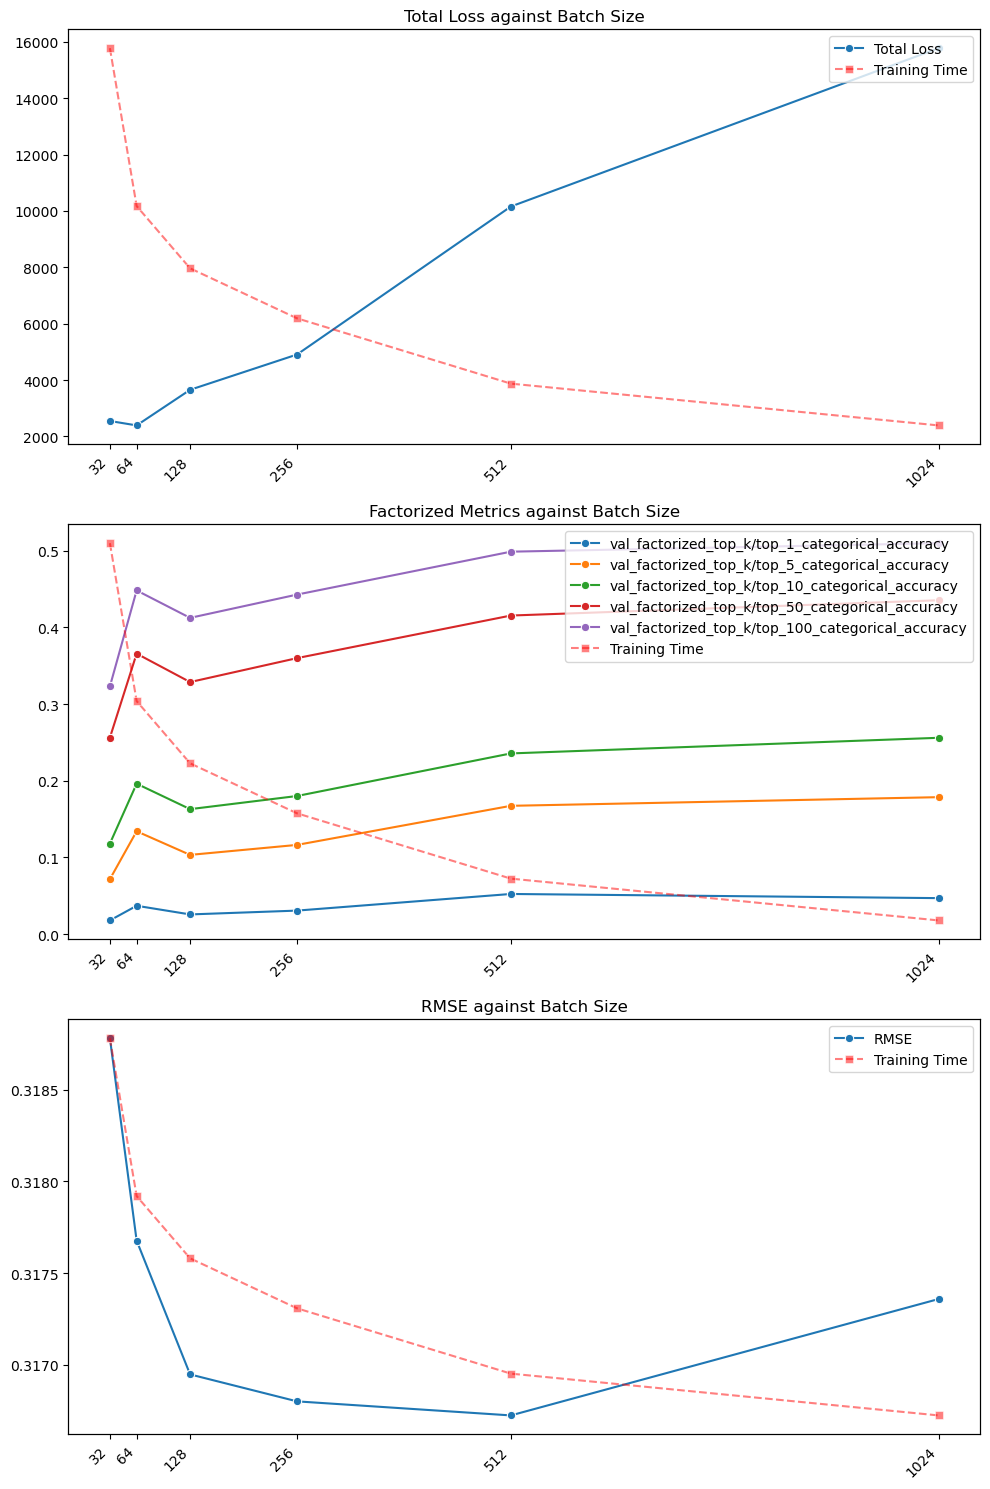

In [12]:
def batch_size_analysis(results: pd.DataFrame):
    _, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

    # Total Loss against Batch Size Plot
    sns.lineplot(data=results, x="batch_size", y="val_total_loss", marker="o", label="Total Loss", ax=axes[0])

    # Factorized Top K Metrics against Batch Size Plot
    for metric in [c for c in results.columns if c.startswith("val_factorized")]:
        sns.lineplot(data=results, x="batch_size", y=metric, marker="o", label=metric, ax=axes[1])

    # RMSE against Batch Size Plot
    sns.lineplot(data=results, x="batch_size", y="val_root_mean_squared_error", marker="o", label="RMSE", ax=axes[2])

    # Add training time against batch size to each plot, removing label, ticks, and tick labels for twinx
    for ax in axes:
        twin_ax = ax.twinx()
        sns.lineplot(
            data=results, x="batch_size", y="training_time",
            linestyle="--", color="red", alpha=0.5,
            label="Training Time",
            marker="s",ax=twin_ax, legend= False
        )

        # Remove the label and ticks for twinx
        twin_ax.set_ylabel("")           # Remove y-axis label for twinx
        twin_ax.set_yticks([])           # Remove y-axis ticks for twinx
        twin_ax.set_yticklabels([])      # Remove y-axis tick labels for twinx

        # Combine legends from both ax and twinx
        ax_handles, ax_labels = ax.get_legend_handles_labels()
        twin_handles, twin_labels = twin_ax.get_legend_handles_labels()
        ax.legend(ax_handles + twin_handles, ax_labels + twin_labels, loc="upper right")  # Combine legends

    # Set titles
    axes[0].set_title("Total Loss against Batch Size")
    axes[1].set_title("Factorized Metrics against Batch Size")
    axes[2].set_title("RMSE against Batch Size")

    # Set labels and ticks
    for ax in axes:
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks(results["batch_size"])
        ax.set_xticklabels(results["batch_size"], rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

batch_size_analysis(results_df)

Batch size selection involves a well-known trade-off between accuracy and performance. Based on the results, a batch size of 64 appears to be the optimal choice in terms of minimizing training time while maintaining high precision.

In [13]:
params['model']['batch_size'] = 64

## Forward Feature Selection

To identify the most impactful features while minimizing noise, I will gradually add features to the model, carefully logging the resulting metrics after each addition. I will start with a baseline which follows a standard matrix factorization model. User feature `user_id` and product feature `product_id` are the minimum required variables to develop a matrix factorization model. I will be adding side features looking for improvements.  

The sequence in which features are added is crucial, as it can significantly influence the features selected by the model. Running the process in a different order may lead to a different subset of features being chosen. This is due to the potential collinearity between features and the fact that adding a new feature doesn't always improve model performance—in some cases, it can even degrade accuracy.

In [14]:
# Read results from Feature Selection
fs_path = LOGS_PATH /  "feature_selection"
params["logs_path"] = fs_path
if not (fs_path / "results.csv").exists():
    # Create model instance
    model = RecommenderEngineModel(
        params=params,
        candidates_ds=prep_products,
        preprocessing= False, # Disable preprocessing
        feature_dim= feature_dim, # Feature dimension is a must, if preprocessing is disabled
    )

    fs = FeatureSelection(
        model = model,
        train = prep_clicks_train,
        val = prep_clicks_val,
        params = copy.deepcopy(params),
    )
    fs.run()
results_df = pd.read_csv(fs_path / "results.csv")

### Results

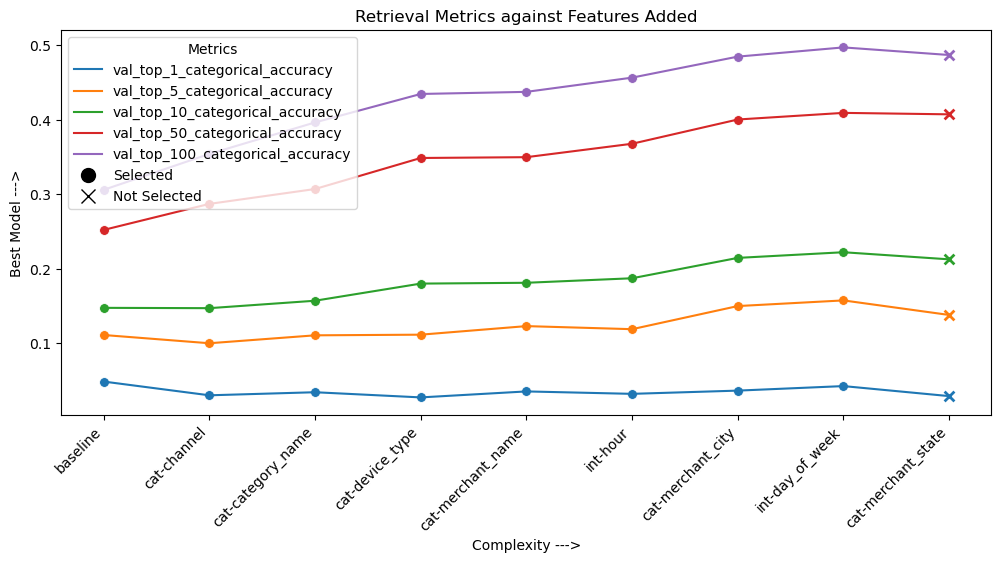

In [15]:
def fs_plot(results: pd.DataFrame, values: list):
    # Plot Retrieval Metrics against Features Added
    fig = plt.figure(figsize=(12, 5))

    for value in values:
        line_plot = sns.lineplot(data=results, x="feature", y=value, label= value, markers=True)
        line_color = line_plot.get_lines()[-1].get_color()
        sns.scatterplot(data=results[results["selected"]], x="feature", y=value, marker="o", color=line_color, s=50)
        sns.scatterplot(data=results[~results["selected"]], x="feature", y=value, marker="x", color=line_color, s=50, linewidth=2)

    legend_elements = [
            Line2D([0], [0], color="black", marker="o", markersize=10,
                              label="Selected", linestyle="None", linewidth=2),
        Line2D([0], [0], color="black", marker="x", markersize=10,
                              label="Not Selected", linestyle="None", linewidth=2)
    ]

    # Add the default legend for lines, and then the manual marker legend
    plt.legend(
        title="Metrics",
        handles=plt.gca().get_legend().legend_handles + legend_elements,
        fontsize= 10
    )
    plt.xticks(rotation=45, ha= "right")
    plt.xlabel("Complexity --->")
    return fig

results_df.columns = [col.replace("val_factorized_top_k/", "val_") for col in results_df.columns]
plot = fs_plot(results_df, values = [c for c in results_df.columns if c.startswith("val_top")])
plt.title("Retrieval Metrics against Features Added")
plt.ylabel("Best Model --->")
plt.show()

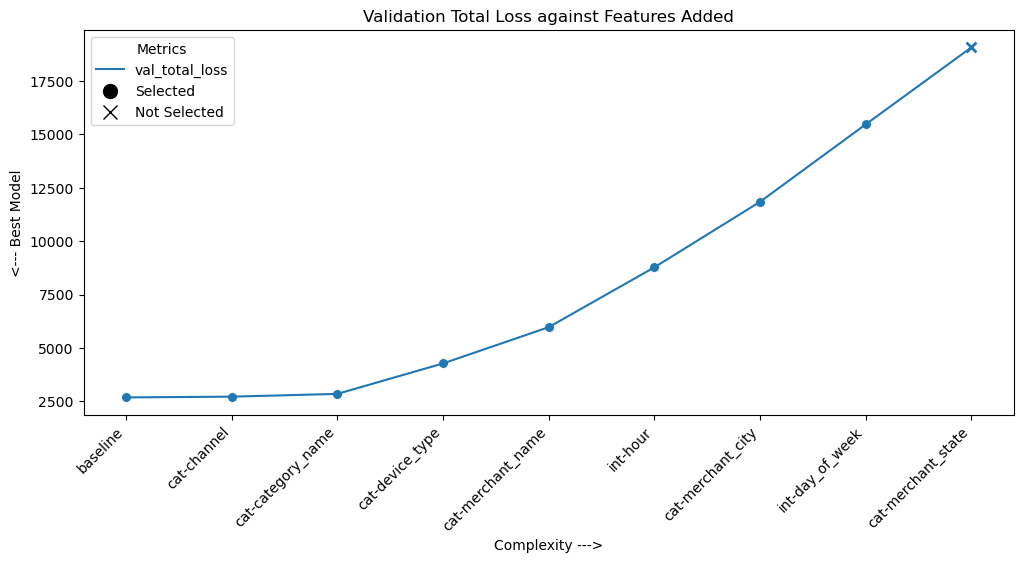

In [16]:
plot = fs_plot(results_df, values = ["val_total_loss"])

plt.title("Validation Total Loss against Features Added")
plt.ylabel("<--- Best Model")
plt.show()

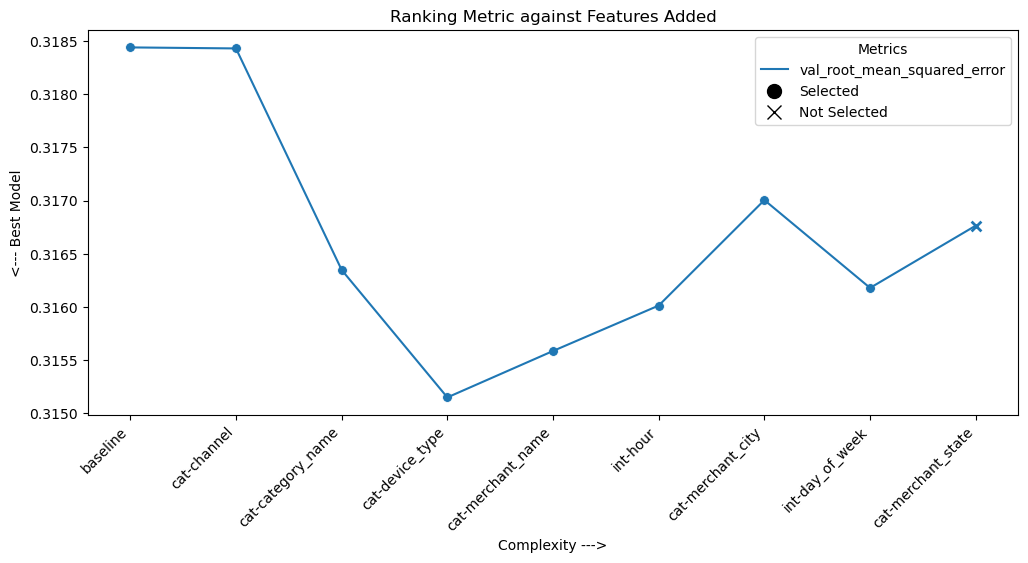

In [17]:
plot = fs_plot(results_df, values = ["val_root_mean_squared_error"])

plt.title("Ranking Metric against Features Added")
plt.ylabel("<--- Best Model")
plt.show()

Based on the results obtained, the following features demonstrate a decrease in accuracy when included in the model:

In [18]:
not_selected_features = results_df[results_df["selected"] == False]["feature"].tolist()
not_selected_features

['cat-merchant_state']

Sequential features, `seq_product_id` and `seq_category_name`, show limited utility, as only 20% of users have recorded multiple clicks. Thus, including this sequential data as a feature does not provide significant value. By excluding sequential features, I am now able to work with shuffled versions of the training and validation datasets, which may further simplify the model.

In [19]:
params["tower"]["query"] = [f for f in params["tower"]["query"] if f not in not_selected_features]
params["tower"]["item"] = [f for f in params["tower"]["item"] if f not in not_selected_features]
params["tower"]

{'query': ListWrapper(['time', 'cat-user_id', 'cat-channel', 'cat-device_type', 'int-hour', 'int-day_of_week', 'text-query_text', 'seq-seq_product_id', 'seq-seq_category_name', 'score']),
 'item': ListWrapper(['cat-product_id', 'cat-category_name', 'cat-merchant_name', 'cat-merchant_city', 'cat-merchant_region', 'int-free_shipping', 'int-is_sold_out', 'int-editor_pick', 'int-on_sale', 'text-product_name', 'disc-sales_last_week', 'disc-sales_last_month', 'disc-sales_last_year', 'disc-price_in_cents', 'disc-reviews', 'norm-sales_last_week', 'norm-sales_last_month', 'norm-sales_last_year', 'norm-price_in_cents', 'norm-reviews'])}

## Deep Retrieval Experiment
Test if it is worth to use deep layers in my retrieval model given the available data.

In [20]:
deep_ret_path = LOGS_PATH / "deep_layers_exp"
params["logs_path"] = deep_ret_path
# Try different architectures from 0 to 2 deep layers
deep_layers = [[32], [64, 32], [128, 63, 32]]

if not (deep_ret_path / "results.csv").exists():
    deep_layers_exp(products_ds, clicks_df, copy.deepcopy(params), deep_layers)
results_df = pd.read_csv(deep_ret_path / "results.csv")

### Results

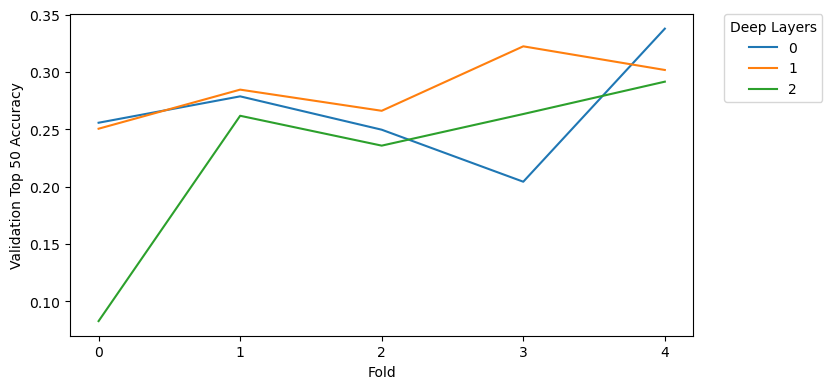

In [21]:
def deep_ret_plot(results: pd.DataFrame):
    fig = plt.figure(figsize=(10, 4))

    palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]
    # Plot the retrieval metric against folds
    sns.lineplot(
        x="fold",
        y="val_factorized_top_k/top_50_categorical_accuracy",
        hue="n_layers",
        data=results,
        palette= palette
    )
    plt.xlabel("Fold")
    plt.ylabel("Validation Top 50 Accuracy")
    plt.xticks(range(0, 5))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0., title="Deep Layers")
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
    plt.show()

deep_ret_plot(results_df)

Note we are focusing solely on analyzing the retrieval metrics, as the deep layers in this context impact only the retrieval model.

Based on the results, the retrieval accuracy decreases when deeper layers are added to both towers of the model. Therefore, I will exclude deep layers from the current implementation to maintain performance. However, these deeper layers will be highly beneficial and strongly recommended as the dataset size increases, allowing the model to better leverage its capacity to learn more complex patterns.

## Resampling
After experimenting with the model, I observed that the **RMSE** metric along the *rating model* showed no improvement. Given the sparsity of my dataset, I plan to address this issue by applying resampling techniques to balance the data, specifically focusing on the `score` feature, which serves as the target variable.

The `score` feature exhibits significant skewness, which could be contributing to the model's poor performance. To mitigate this, I will utilize the *ImbalancedLearningRegression* package, implementing various resampling strategies. The goal is to redistribute the data more evenly across the range of `score` values, thus reducing the imbalance and potentially enhancing the model’s predictive accuracy.

By balancing the dataset through resampling, I aim to improve the RMSE metric and overall performance of the ranking task.

Reference:  
*Wu, W., Kunz, N., & Branco, P. (2022, September). ImbalancedLearningRegression-A Python Package to Tackle the Imbalanced Regression Problem. In Joint European Conference on Machine Learning and Knowledge Discovery in Databases (pp. 645-648). Cham: Springer Nature Switzerland.*

In [22]:
params["tower"]["query"].remove('seq-seq_product_id')
params["tower"]["query"].remove('seq-seq_category_name')

[15:02:35] INFO     Resample training

           INFO     Random Oversample

r_index: 100%|##########| 5480/5480 [00:02<00:00, 2547.75it/s]


[15:02:43] INFO     Random Undersampling

new_index: 100%|##########| 8568/8568 [00:02<00:00, 3039.36it/s]


[15:03:11] INFO     Gaussian Noise

r_index: 100%|##########| 2392/2392 [00:21<00:00, 108.88it/s]


Original shape: (17136, 28)
RO shape: (22616, 28)
RU shape: (11656, 28)
Gaussian Noise shape: (17136, 28)


[15:04:07] INFO     Load as dataset

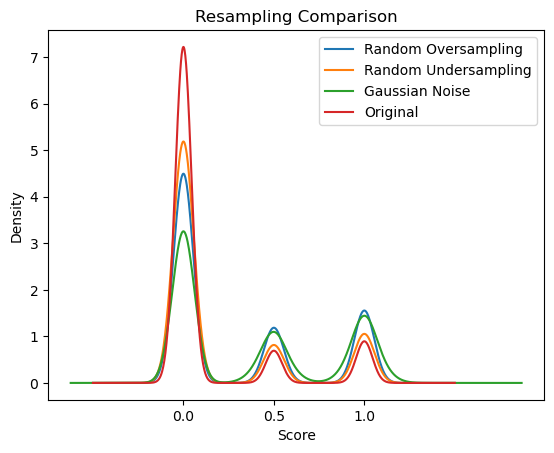

[15:04:08] INFO     Training model for original dataset (1/4)

2025-04-14 15:04:19.248933: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f365698b7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-14 15:04:19.248973: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-04-14 15:04:19.253811: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-14 15:04:19.264370: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1744653859.294770   20144 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[15:04:46] INFO     Training model for RO dataset (2/4)

2025-04-14 15:05:20.480399: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[15:05:20] INFO     Training model for RU dataset (3/4)

[15:05:54] INFO     Training model for GN dataset (4/4)

[15:06:27] INFO     Results saved to                                                                               
                    /home/sagravela/code/recommendation_system/recommendation_engine/output/logs_test/resample/resu
                    lts.csv

In [23]:
resampling_path = LOGS_PATH / "resample"
params["logs_path"] = resampling_path
if not (resampling_path / "results.csv").exists():
    results_df = resample_exp(
        copy.deepcopy(params),
        train_df = clicks_train_df_sh,
        val_ds = clicks_val_ds_sh,
        candidates_ds= products_ds,
        features = features
    )
results_df = pd.read_csv(resampling_path / "results.csv")

### Results

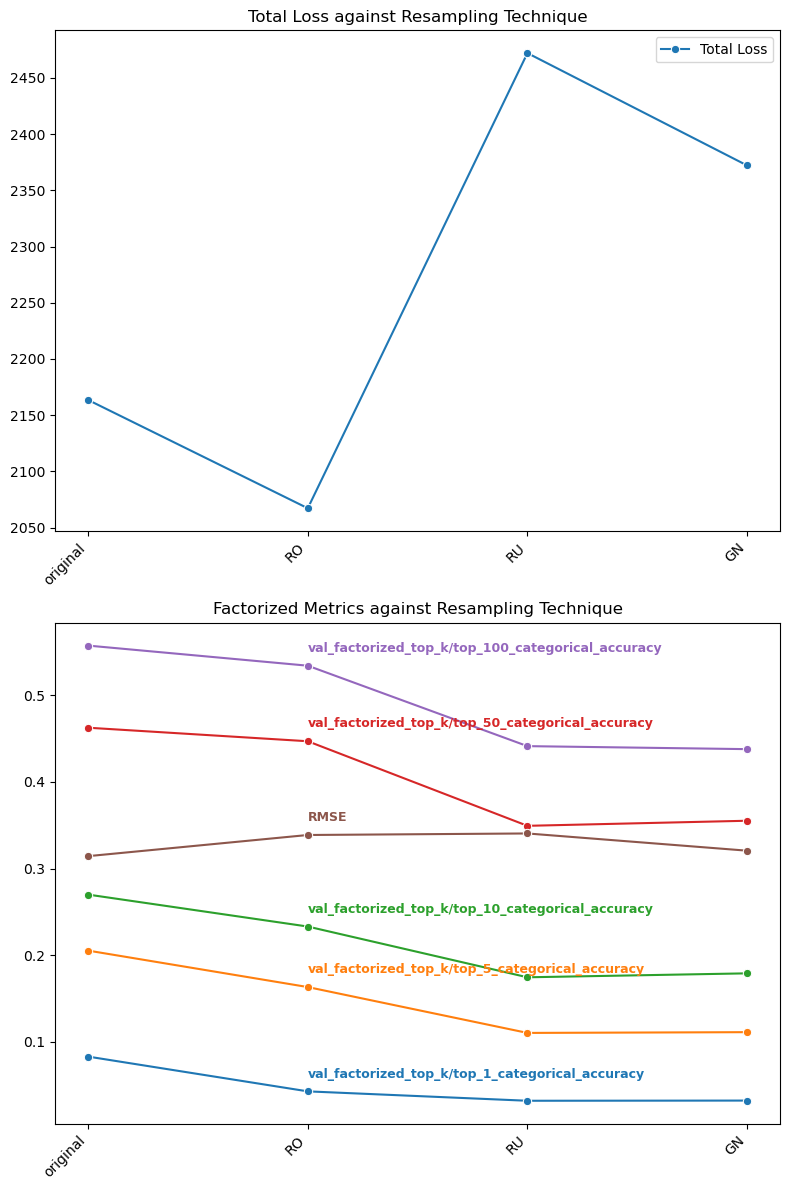

In [24]:
def resampling_plot(results: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

    # Total Loss against Batch Size Plot
    sns.lineplot(data=results, x="name", y="val_total_loss", marker="o", label="Total Loss", ax=axes[0])

    # Factorized Top K Metrics against Batch Size Plot
    retrieval_metrics = [c for c in results.columns if c.startswith("val_factorized")]
    for metric in retrieval_metrics:
        sns.lineplot(data=results, x="name", y=metric, marker="o", label=metric, ax=axes[1])

    # RMSE against Batch Size Plot
    sns.lineplot(data=results, x="name", y="val_root_mean_squared_error", marker="o", label="RMSE", ax=axes[1])

    # Set titles
    axes[0].set_title("Total Loss against Resampling Technique")
    axes[1].set_title("Factorized Metrics against Resampling Technique")

    # Set labels and ticks
    for ax in axes:
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks(results["name"])
        ax.set_xticklabels(results["name"], rotation=45, ha="right")

    # Place labels directly over the lines
    for line, label in zip(plt.gca().get_lines(), retrieval_metrics + ["RMSE"]):
        x = line.get_xdata()[1]
        y = line.get_ydata()[1] + 0.02

        plt.text(x, y, label, color=line.get_color(), fontweight="bold", va="center", fontsize= 9)

    plt.legend().set_visible(False)
    plt.tight_layout()
    plt.show()

resampling_plot(results_df)

**Conclusion**: The resampling techniques applied did not result in a significant improvement over the original dataset. The ranking model's performance remained largely unchanged, suggesting that the model may be limited by the inherent sparsity and lack of sufficient data. This could indicate that the model has already extracted most of the learnable patterns from the data, and further improvements may require either more comprehensive data or a different modeling approach.

# Saving

In [ ]:
# Save parameters
params.pop("logs_path")
json.dump(params, open(root_path / "output" / "model" / "parameters" / "params_v2.json", "w"), indent=4)

# Save processed dataset for further usage
prep_clicks_train_sh.save(str(root_path / "data" / "processed" / "prep_train"))
prep_clicks_val_sh.save(str(root_path / "data" / "processed" / "prep_val"))
products_ds.save(str(root_path / "data" / "processed" / "candidates"))